# ToyDiT

We want to asses how well a DiT is able to retain information that could be lost due to the number of LayerNormalizations in the network.

To test this quickly, we train two variants of DiT to generate very simple, contant, synthetic data: $x = [0]^{2\times2\times2}$. In other words, we are learning to generate empty images of 2 per 2 pixels with 2 channels.

The training objective is then given a noise $\epsilon$ and a diffusion timestep $t$, to predict $\alpha_t\epsilon$ where $\alpha_t$. To do so, the network needs to learn the identity function.
The training script is in `train_toy.py`.

Here, we plot the values of each "pixel" compare a model with layer norm and one without.

In [1]:
import torch
torch.set_grad_enabled(False)

image_size = 2
in_channels = 2
device = 'cuda'

## Load Checkpoints

In [29]:
from models import DiT_XS_1

checkpoint_none_path = 'results/001-Toy-DiT-XS-1-none/checkpoints/0010000.pt'
model_none = DiT_XS_1(input_size=image_size, normalization="none", num_classes=1, in_channels=in_channels, class_dropout_prob=0).to(device)
model_none.load_state_dict(torch.load(checkpoint_none_path)['model']) # no EMA
model_none.eval() # important!
print(f'Loaded checkpoint {checkpoint_none_path}.')

checkpoint_ln_path = 'results/000-Toy-DiT-XS-1-layer-norm/checkpoints/0010000.pt'
model_ln = DiT_XS_1(input_size=image_size, normalization="layer-norm", num_classes=1, in_channels=in_channels, class_dropout_prob=0).to(device)
model_ln.load_state_dict(torch.load(checkpoint_ln_path)['model'])
model_ln.eval() # important!
print(f'Loaded checkpoint {checkpoint_ln_path}.')

Loaded checkpoint results/025-Toy-DiT-XS-1-none-wd0/checkpoints/0010000.pt.
Loaded checkpoint results/024-Toy-DiT-XS-1-layer-norm-wd0/checkpoints/0010000.pt.


## Sample from the pretrained

In [30]:
from diffusion import create_diffusion

# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 1000 #@param {type:"slider", min:0, max:1000, step:1}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = 100
z = torch.randn(n, in_channels, image_size, image_size, device=device)
y = torch.zeros(n, device=device).long()

# Sample images:
model_kwargs = dict(y=y)

samples_none = diffusion.p_sample_loop(
    model_none.forward, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)

samples_ln = diffusion.p_sample_loop(
    model_ln.forward, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

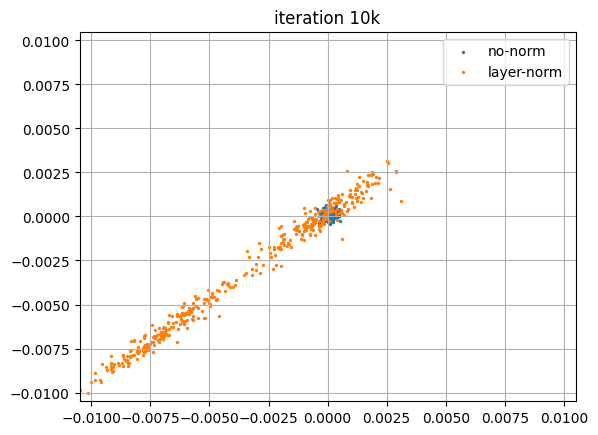

In [31]:
import matplotlib.pyplot as plt
from train_toy import sample_toy_data

samples_none_2d = samples_none.view(-1, image_size, image_size).cpu()
plt.scatter(samples_none_2d[:,0], samples_none_2d[:,1], s=2, label='no-norm')

samples_ln_2d = samples_ln.view(-1, image_size, image_size).cpu()
plt.scatter(samples_ln_2d[:,0], samples_ln_2d[:,1], s=2, label='layer-norm')

max_value = max(samples_none_2d.abs().max().item(), samples_ln_2d.abs().max().item())
plt.xlim(-max_value, max_value)
plt.ylim(-max_value, max_value)

plt.title('iteration 10k')

plt.grid()
plt.legend()